In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/drive/MyDrive/Waste_Classification/Dataset_Resized"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
image_size = (150, 150)
batch_size = 32 

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4369 files belonging to 9 classes.
Using 3496 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4369 files belonging to 9 classes.
Using 873 files for validation.


In [ ]:
classes = train_ds.class_names
numClasses = len(train_ds.class_names)
print(classes)
print(numClasses)

['Aluminium', 'Cardboard', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']
9


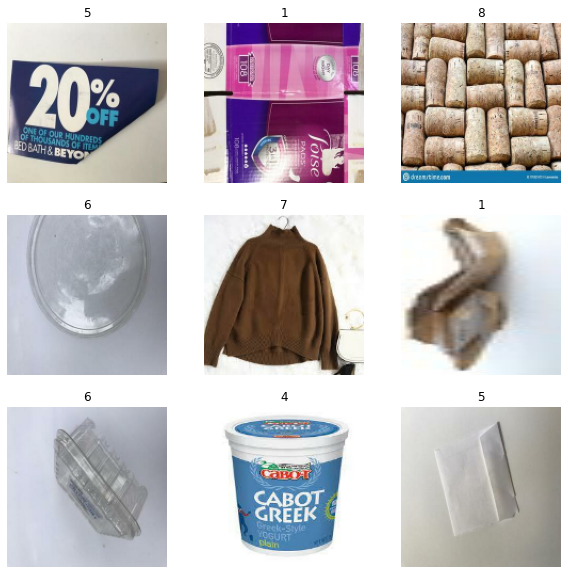

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

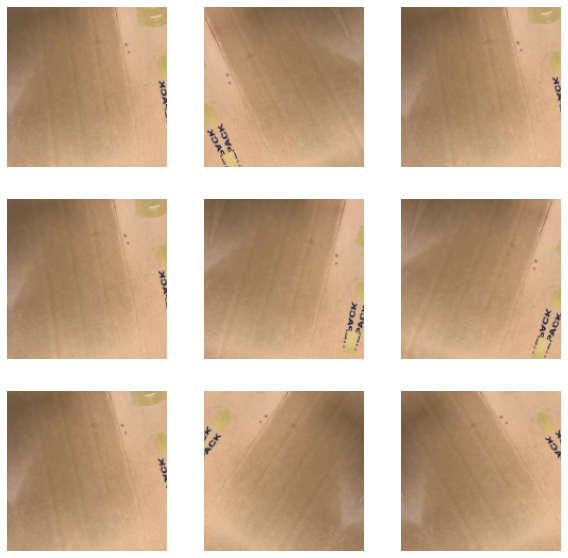

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

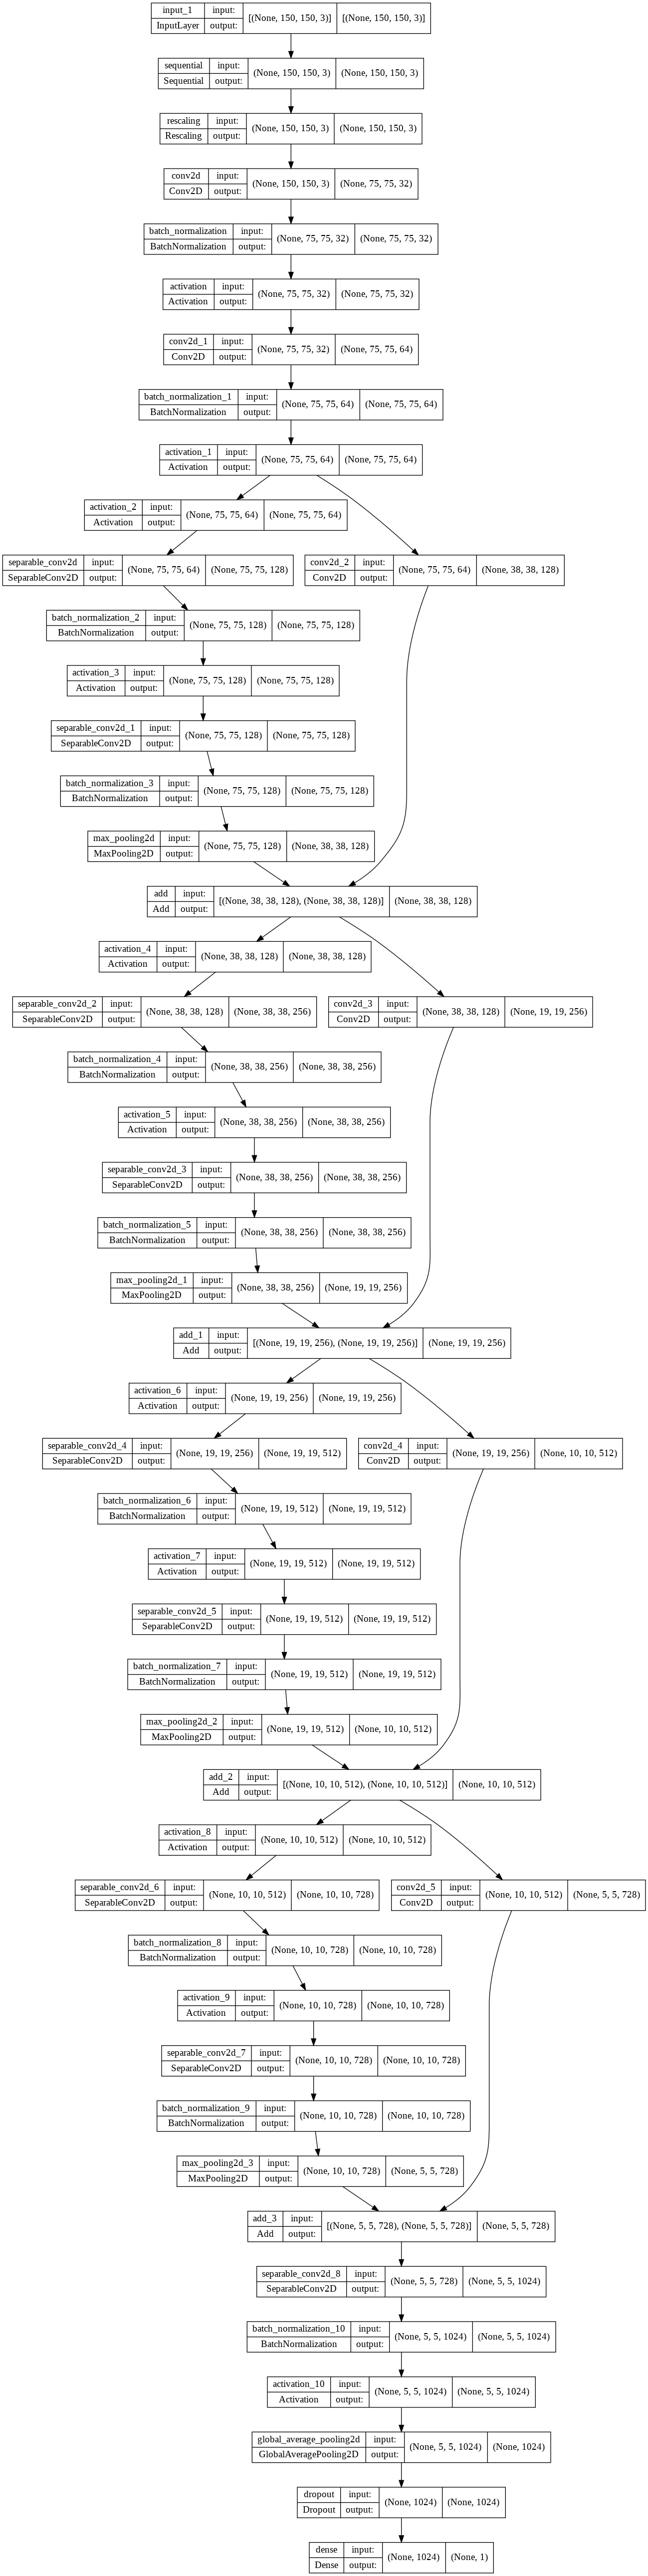

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3)(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2)(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2)(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 9:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=9)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
110/110 [==============================] - 36s 185ms/step - loss: nan - accuracy: 0.1130 - val_loss: nan - val_accuracy: 0.1031
Epoch 2/50
110/110 [==============================] - 19s 173ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 3/50
110/110 [==============================] - 20s 174ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 4/50
110/110 [==============================] - 20s 180ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 5/50
110/110 [==============================] - 20s 180ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 6/50
110/110 [==============================] - 20s 182ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 7/50
110/110 [==============================] - 20s 182ms/step - loss: nan - accuracy: 0.1124 - val_loss: nan - val_accuracy: 0.1031
Epoch 8/50
110/110 [=======